<a href="https://colab.research.google.com/github/kozz84/Image-analysis/blob/main/Image_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import glob, os
import numpy as np
from skimage import io
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage.segmentation import clear_border
from skimage import morphology
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FILE NAME: 210902_#6_100_10_1um_i004.tif
DATE: 09/03/2021
PIXEL SIZE: 2.480469 nm
IMAGE SIZE: 2560x1920


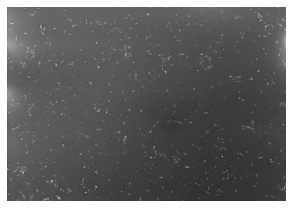

In [62]:
img = io.imread('/content/drive/MyDrive/CIOP/images/210902_#6_100_10_1um_i004.tif', as_gray=True)
img = np.array(img).astype(np.int32)

with open(f'/content/drive/MyDrive/CIOP/images/210902_#6_100_10_1um_i004.txt','r') as txt_file:
    txt = txt_file.read()
    del txt_file
    txt=txt.split('\n')
    txt=txt[1:-1]
    sem_dict = {}
    for row in txt:
        row = row.split('=')
        sem_dict.update({row[0]:  row[1]}) 
    print('FILE NAME:',sem_dict['ImageName'])
    print('DATE:',sem_dict['Date'] )    
    print('PIXEL SIZE:', sem_dict['PixelSize'],'nm')
    print('IMAGE SIZE:', sem_dict['DataSize'])
    pixelsize = float(sem_dict['PixelSize'])
    width, height = sem_dict['DataSize'].split('x')
    width, height = int(width), int(height)
    if height == 1920:
        img = img[0:1780,0:2560]
        height = 1780
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(img,vmax=255, cmap='gray')
plt.show()

In [5]:
#pd.DataFrame(sem_dict,index=[0]).T

In [6]:
def image_info(img):
    im = img.copy()
    print('Max:',im.max())
    print('Min:',im.min())
    print('Median:',np.median(im))
    print('Average:',np.average(im))
    im_flatten = im.flatten()
    print('IMAGE:')
    im_flatten = im.flatten()
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(im,vmax=255, cmap='gray')
    plt.show()

    print('IMAGE HIST:')
    plt.figure(figsize=(4,2))
    plt.hist(im_flatten, bins=256,histtype='stepfilled', range=(im.min(),im.max()))
    plt.yscale('log')
    plt.show()

    median_img=[]
    
    average_img =[]
    max_img = []
    num_rec_x=20
    num_rec_y=20
    rec_size_x = int(int(height)/num_rec_x)
    rec_size_y = int(int(width)/num_rec_y)
    for i in range(num_rec_x):
        for j in range(num_rec_y):
            x_min=i*rec_size_x
            y_min=j*rec_size_y
            x_max=x_min+rec_size_x
            y_max=y_min+rec_size_y
            median_img.append(int(np.median(im[x_min:x_max,y_min:y_max])))
            average_img.append(int(np.average(im[x_min:x_max,y_min:y_max])))
            max_img.append(int(np.max(im[x_min:x_max,y_min:y_max])))
    print('Average:')            
    plt.figure(figsize=(10,8))
    plt.plot(average_img)
    plt.show()
    #plt.plot(max_img)
    plt.boxplot(median_img)
    plt.show()
    Q1 = np.percentile(median_img , 25)
    print(Q1)
    Q3 = np.percentile(median_img , 75)
    print(Q3)
    IQR = Q3 - Q1
    upper_bound = Q3+(1.5*IQR)
    lower_bound = Q1-(1.5*IQR)
    print(upper_bound)
    print(lower_bound)
    median_img = np.reshape(median_img, (20, 20))
    average_img =np.reshape(average_img,(20,20))
    max_img=np.reshape(max_img,(20,20))
    print('Median_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(median_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()
    print('Average_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(average_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()
    print('max/average_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(max_img/average_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()
#image_info(img)

In [63]:
def uniform(num_rec_x,num_rec_y):
    img2 = np.copy(img)
    rec_size_x = int(int(height)/num_rec_x)
    rec_size_y = int(int(width)/num_rec_y)
    print("Median Rectangle Box size:",rec_size_x,"x", rec_size_y)
    print("Median intensity:",np.median(img))
    median_img=[]
    mask = np.ones(shape=(1780,2560), dtype=bool)
    for i in range(num_rec_x):
        for j in range(num_rec_y):
            x_min=i*rec_size_x
            y_min=j*rec_size_y
            x_max=x_min+rec_size_x
            y_max=y_min+rec_size_y
            if j == (num_rec_y-1):
                y_max = width
            if i == (num_rec_x-1):
                x_max = height
            median_img.append(np.median(img[x_min:x_max,y_min:y_max]))
            img2[x_min:x_max,y_min:y_max]=img[x_min:x_max,y_min:y_max] - np.median(img[x_min:x_max,y_min:y_max])
    Q1 = np.percentile(median_img , 25)
    Q3 = np.percentile(median_img , 75)
    IQR = Q3 - Q1
    upper_bound = Q3+(1.5*IQR)
    lower_bound = Q1-(1.5*IQR)

    for i in range(num_rec_x):
        for j in range(num_rec_y):
             x_min=i*rec_size_x
             y_min=j*rec_size_y
             x_max=x_min+rec_size_x
             y_max=y_min+rec_size_y
             if np.median(img[x_min:x_max,y_min:y_max]) > upper_bound or np.median(img[x_min:x_max,y_min:y_max]) < lower_bound :
                print(np.median(img[x_min:x_max,y_min:y_max]))
                img2[x_min:x_max,y_min:y_max] = 0
                mask[x_min:x_max,y_min:y_max] = False
    img2[img2<0] = 0
    mask[0,0:]=False
    mask[-1,0:]=False
    mask[0:,0]=False
    mask[0:,-1]=False
    return img2, median_img, mask
img2, median_img,mask = uniform(20,20)

Median Rectangle Box size: 89 x 128
Median intensity: 113.0
161.0


In [8]:
mask

array([[False, False, False, ..., False, False, False],
       [False,  True,  True, ...,  True,  True, False],
       [False,  True,  True, ...,  True,  True, False],
       ...,
       [False,  True,  True, ...,  True,  True, False],
       [False,  True,  True, ...,  True,  True, False],
       [False, False, False, ..., False, False, False]])

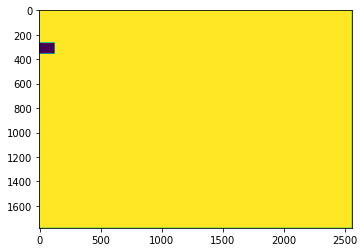

In [9]:
plt.imshow(mask)

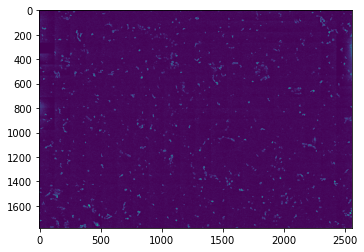

In [10]:
plt.imshow(img2)

In [ ]:
image_info(img2)

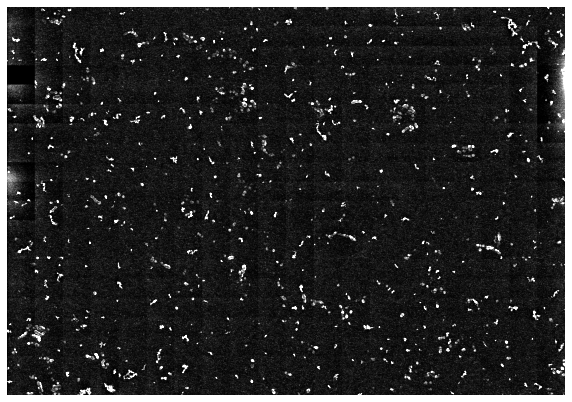

In [12]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img2,vmax=40, cmap='gray')
plt.show()

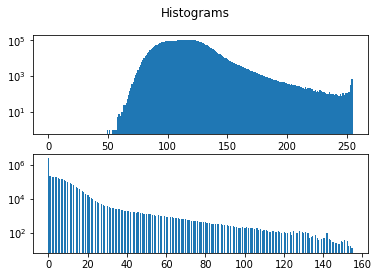

In [64]:
def histograms():
    img_flatten = img.flatten()
    img2_flatten = img2.flatten()
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    fig.suptitle('Histograms')
    ax1.hist(img_flatten, bins=256, range=(0,255))
    ax2.hist(img2_flatten, bins=256, range=(0,155))
histograms()

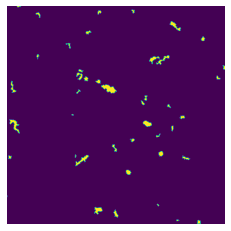

In [106]:
def segmentation(low,denoise,small,erosion=1):
   # img_denoised = denoise_tv_chambolle(img2, weight=denoise)
    img_denoised = img2.copy()
    img_segm = (img2 > np.median(img_denoised)+low) & (img_denoised <= 255)
    img_segm = morphology.remove_small_objects(img_segm, small)
    img_segm = morphology.area_closing(img_segm)
    for i in range(erosion):
        img_segm = morphology.binary_erosion(img_segm)
    img_segm = morphology.remove_small_objects(img_segm, small)
    for i in range(erosion-1):     
        img_segm = morphology.binary_dilation(img_segm)
    img_segm = morphology.binary_dilation(img_segm)
    img_segm = morphology.binary_erosion(img_segm)
    plt.imshow(img_segm[1000:1500,500:1000])
    plt.axis('off')
    plt.show()
    return img_segm

img_segm = segmentation(8,6,10)

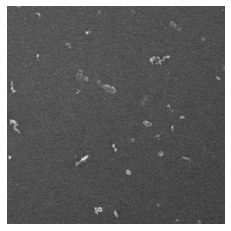

In [107]:
plt.imshow(img[1000:1500,500:1000],vmin=50,cmap='gray')
plt.axis('off')
plt.show()

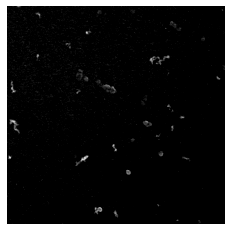

KeyboardInterrupt: ignored

Exception ignored in: 'skimage.morphology._max_tree._is_valid_neighbor'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in unravel_index
KeyboardInterrupt


KeyboardInterrupt: ignored

In [98]:
plt.imshow(img[1000:1500,500:1000],vmin=0,cmap='gray')
plt.axis('off')
plt.show()
particles = []
for i in range(1,11):
    img_segm = segmentation(i,6,10,1)
    img2_label, img2_label_overlay, data_nm = label_img()
    particles.append([i,len(data_nm)])
    #print(i,len(data_nm))
particles = pd.DataFrame(particles, columns=(['segm','number of particles']))

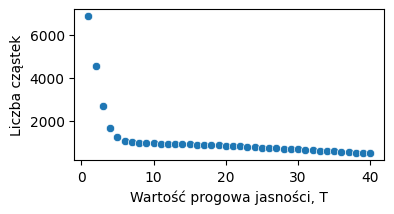

In [83]:
plt.figure(figsize=(4,2),dpi=100)
sns.scatterplot(data=particles,x='segm',y='number of particles')
plt.xlabel('Wartość progowa jasności, T')
plt.ylabel('Liczba cząstek')
#plt.yscale('log')
yinterp = np.interp(particles['segm'], particles['segm'], particles['number of particles'])

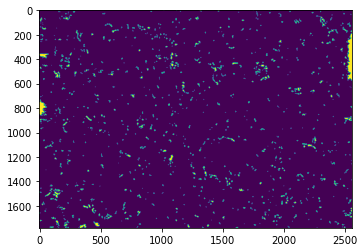

In [108]:
plt.imshow(img_segm)

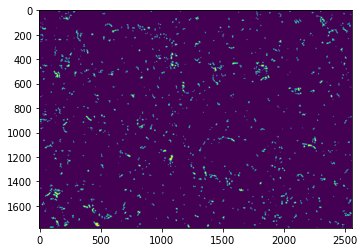

In [110]:
plt.imshow(clear_border(img_segm))

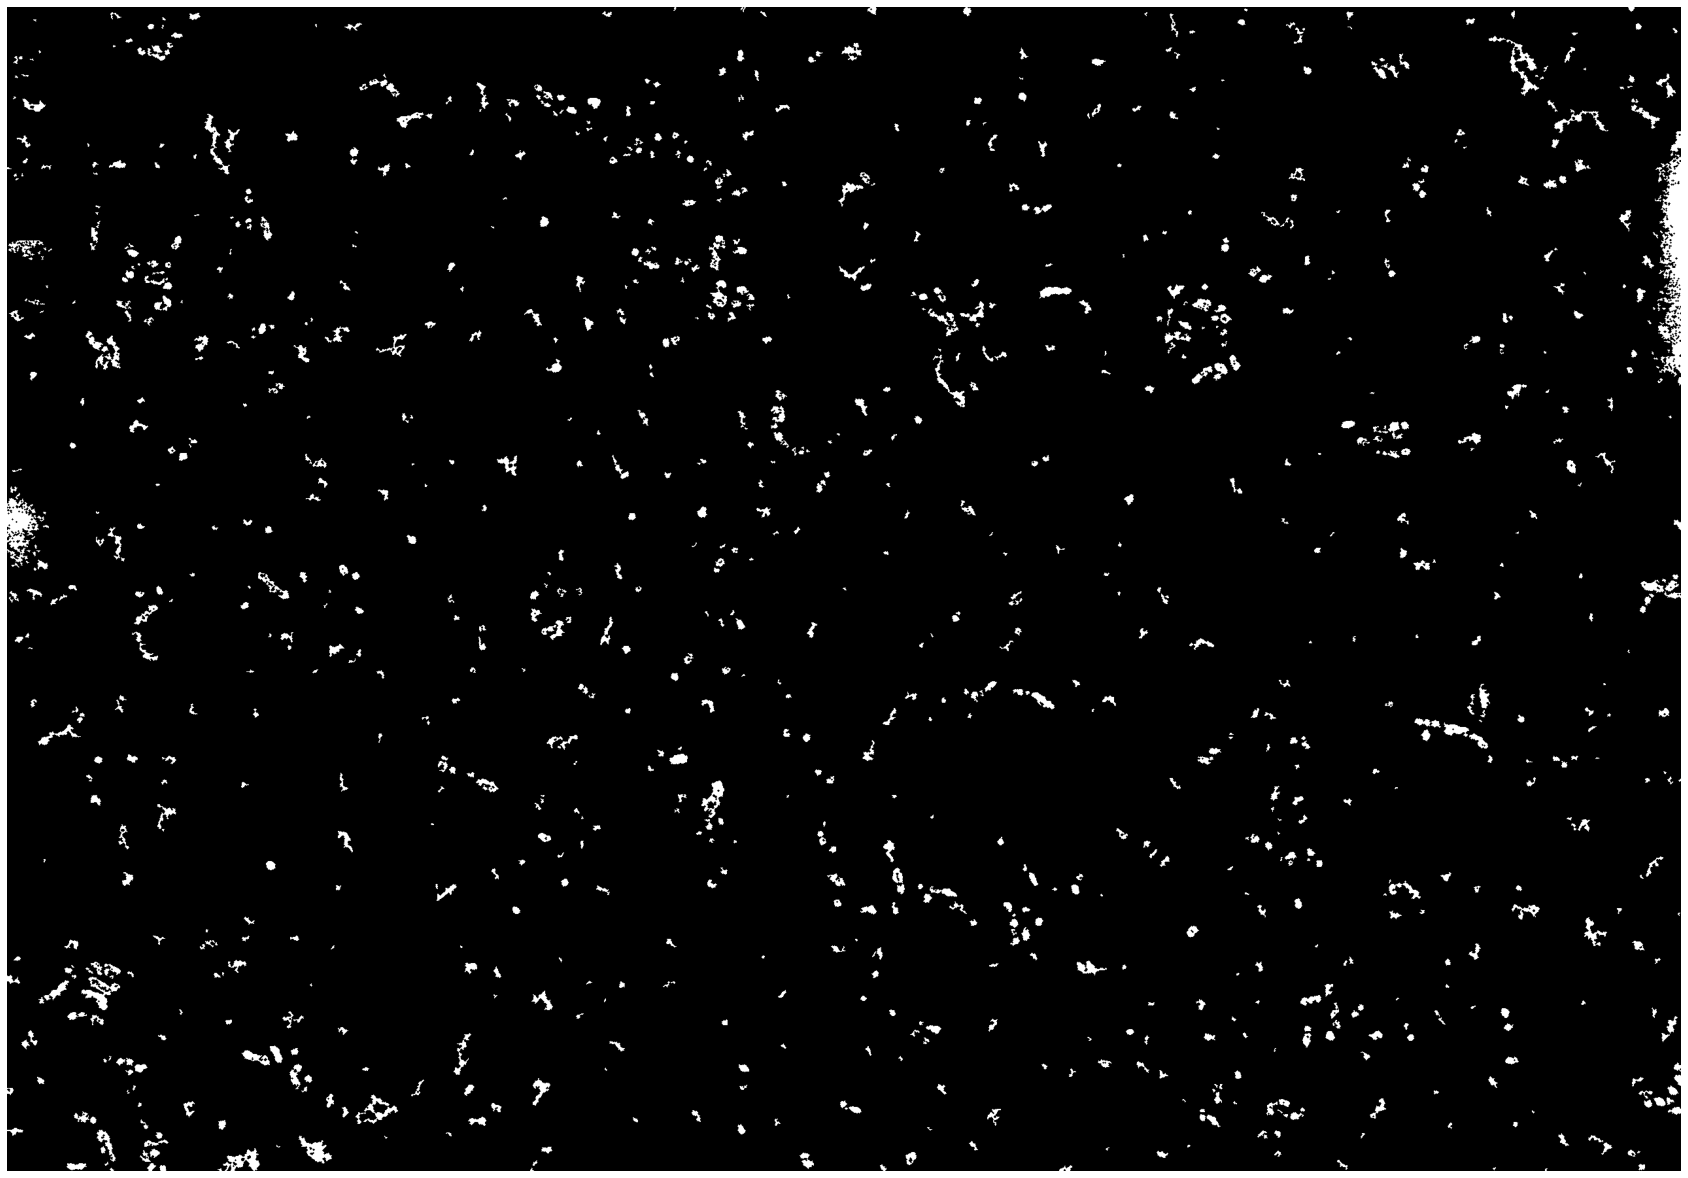

In [15]:
plt.figure(figsize=(30,30))
plt.axis('off')
plt.imshow(img_segm,vmax=1, cmap='gray')

In [104]:
def label_img():
    img2_label = label(img_segm)
    img2_label = clear_border(img2_label, mask=mask)
    img2_label_overlay = label2rgb(img2_label, bg_label=0)
    props = regionprops(img2_label, extra_properties=())
    props = regionprops_table(img2_label, img,
                           properties=['area',
                                       'convex_area',
                                       'equivalent_diameter', 
                                       'major_axis_length', 
                                       'minor_axis_length',
                                       'bbox', 'perimeter',
                                       'feret_diameter_max', 
                                       'image'
                                       ])
    props = pd.DataFrame(props)
    props['img'] = [img]*len(props)
    for i in range(len(props)):
        props.loc[i,'img'] = [img[int(props['bbox-0'][i]):int(props['bbox-2'][i]),
                                  int(props['bbox-1'][i]):int(props['bbox-3'][i])]]
    data_nm = props.copy()
    data_nm = data_nm.drop(columns=['image',
                                    'bbox-0', 
                                    'bbox-1', 
                                    'bbox-2', 
                                    'bbox-3',
                                    'img'])

    data_nm[data_nm.columns[0:2]].apply(lambda x:x*pixelsize)
    data_nm[data_nm.columns[0:6]].apply(lambda x:x*pixelsize)
    data_nm['circularity'] =data_nm['area']/data_nm['convex_area']
    data_nm.to_csv('data_nm.csv')
    return img2_label, img2_label_overlay, data_nm
img2_label, img2_label_overlay, data_nm = label_img()

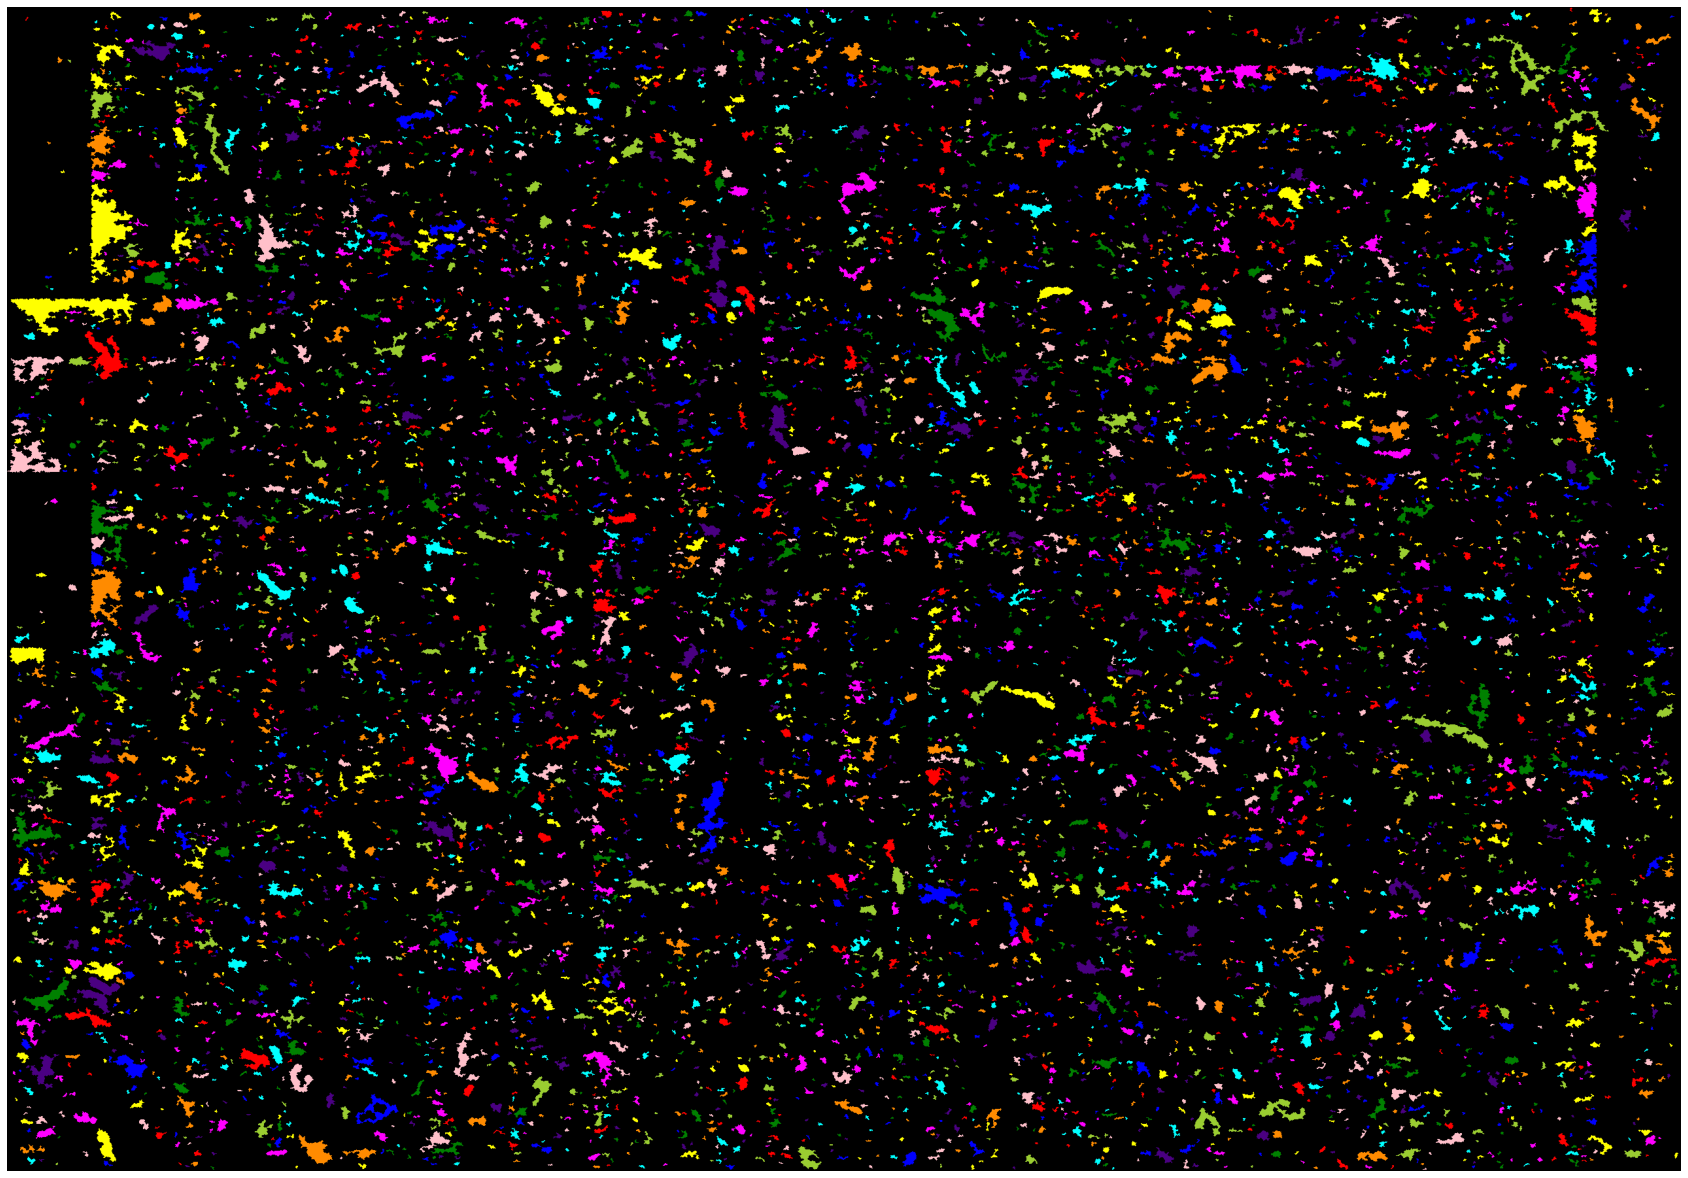

In [105]:
plt.figure(figsize=(30,30))
plt.axis('off')
plt.imshow(img2_label_overlay)

In [18]:
data_nm

,area,convex_area,equivalent_diameter,major_axis_length,minor_axis_length,bbox-0,bbox-1,bbox-2,bbox-3,perimeter,feret_diameter_max,image,img,circularity
0,16,18,4.513517,5.523893,3.764851,2,1892,7,1897,13.071068,5.385165,"[[False, True, False, False, False], [True, Tr...","[[140, 142, 145, 143, 151], [146, 138, 146, 14...",0.888889
1,45,54,7.569398,11.188765,5.651149,5,2300,18,2306,26.520815,13.038405,"[[False, False, False, False, True, False], [F...","[[119, 130, 130, 132, 137, 136], [124, 113, 12...",0.833333
2,66,98,9.166996,15.450434,7.691621,6,910,15,925,45.941125,15.132746,"[[False, False, False, False, True, False, Fal...","[[141, 141, 125, 134, 136, 151, 131, 125, 139,...",0.673469
3,34,44,6.579525,12.329570,3.876426,6,1152,15,1162,23.727922,12.206556,"[[False, True, False, False, False, False, Fal...","[[139, 146, 141, 117, 127, 122, 117, 126, 114,...",0.772727
4,72,92,9.574615,11.961347,9.468936,7,2048,20,2059,39.455844,13.892444,"[[False, False, True, True, False, False, Fals...","[[129, 150, 163, 151, 147, 153, 153, 156, 155,...",0.782609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,30,38,6.180387,10.014497,4.234627,1764,804,1772,811,23.313708,10.000000,"[[False, False, False, False, False, True, Tru...","[[94, 97, 94, 102, 111, 115, 117], [125, 118, ...",0.789474
1113,17,24,4.652426,7.577055,3.606991,1766,149,1772,155,13.071068,7.211103,"[[False, False, False, False, True, True], [Fa...","[[136, 118, 119, 133, 131, 124], [121, 115, 11...",0.708333
1114,235,287,17.297725,32.088697,10.275407,1768,91,1779,122,81.083261,31.064449,"[[False, True, False, True, False, True, True,...","[[122, 132, 152, 187, 206, 220, 202, 188, 172,...",0.818815
1115,73,89,9.640876,10.734971,9.429118,1769,2495,1779,2505,36.627417,12.206556,"[[False, False, False, True, False, False, Fal...","[[95, 106, 108, 127, 125, 120, 100, 106, 110, ...",0.820225


In [19]:
import random

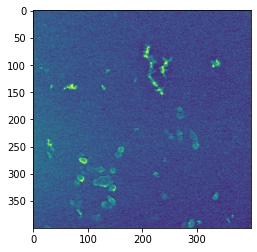

In [42]:
plt.imshow(img[100:500,100:500])
plt.show()

605


(-0.5, 51.5, 59.5, -0.5)

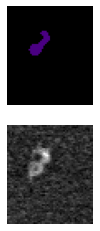

In [36]:
i = random.randint(0, len(data_nm))
print(i)
y_min = data_nm['bbox-0'][i]
y_max = data_nm['bbox-2'][i]
x_min = data_nm['bbox-1'][i]
x_max = data_nm['bbox-3'][i]

y_min -=int((y_max-y_min))
y_max +=int((y_max-y_min))
x_min -= int((x_max-x_min))
x_max += int((x_max-x_min))
plt.subplot(211)
plt.imshow(img2_label_overlay[y_min:y_max,x_min:x_max], cmap='gray')
plt.axis('off')
plt.subplot(212)
plt.imshow(img[y_min:y_max,x_min:x_max], cmap='gray')
plt.axis('off')

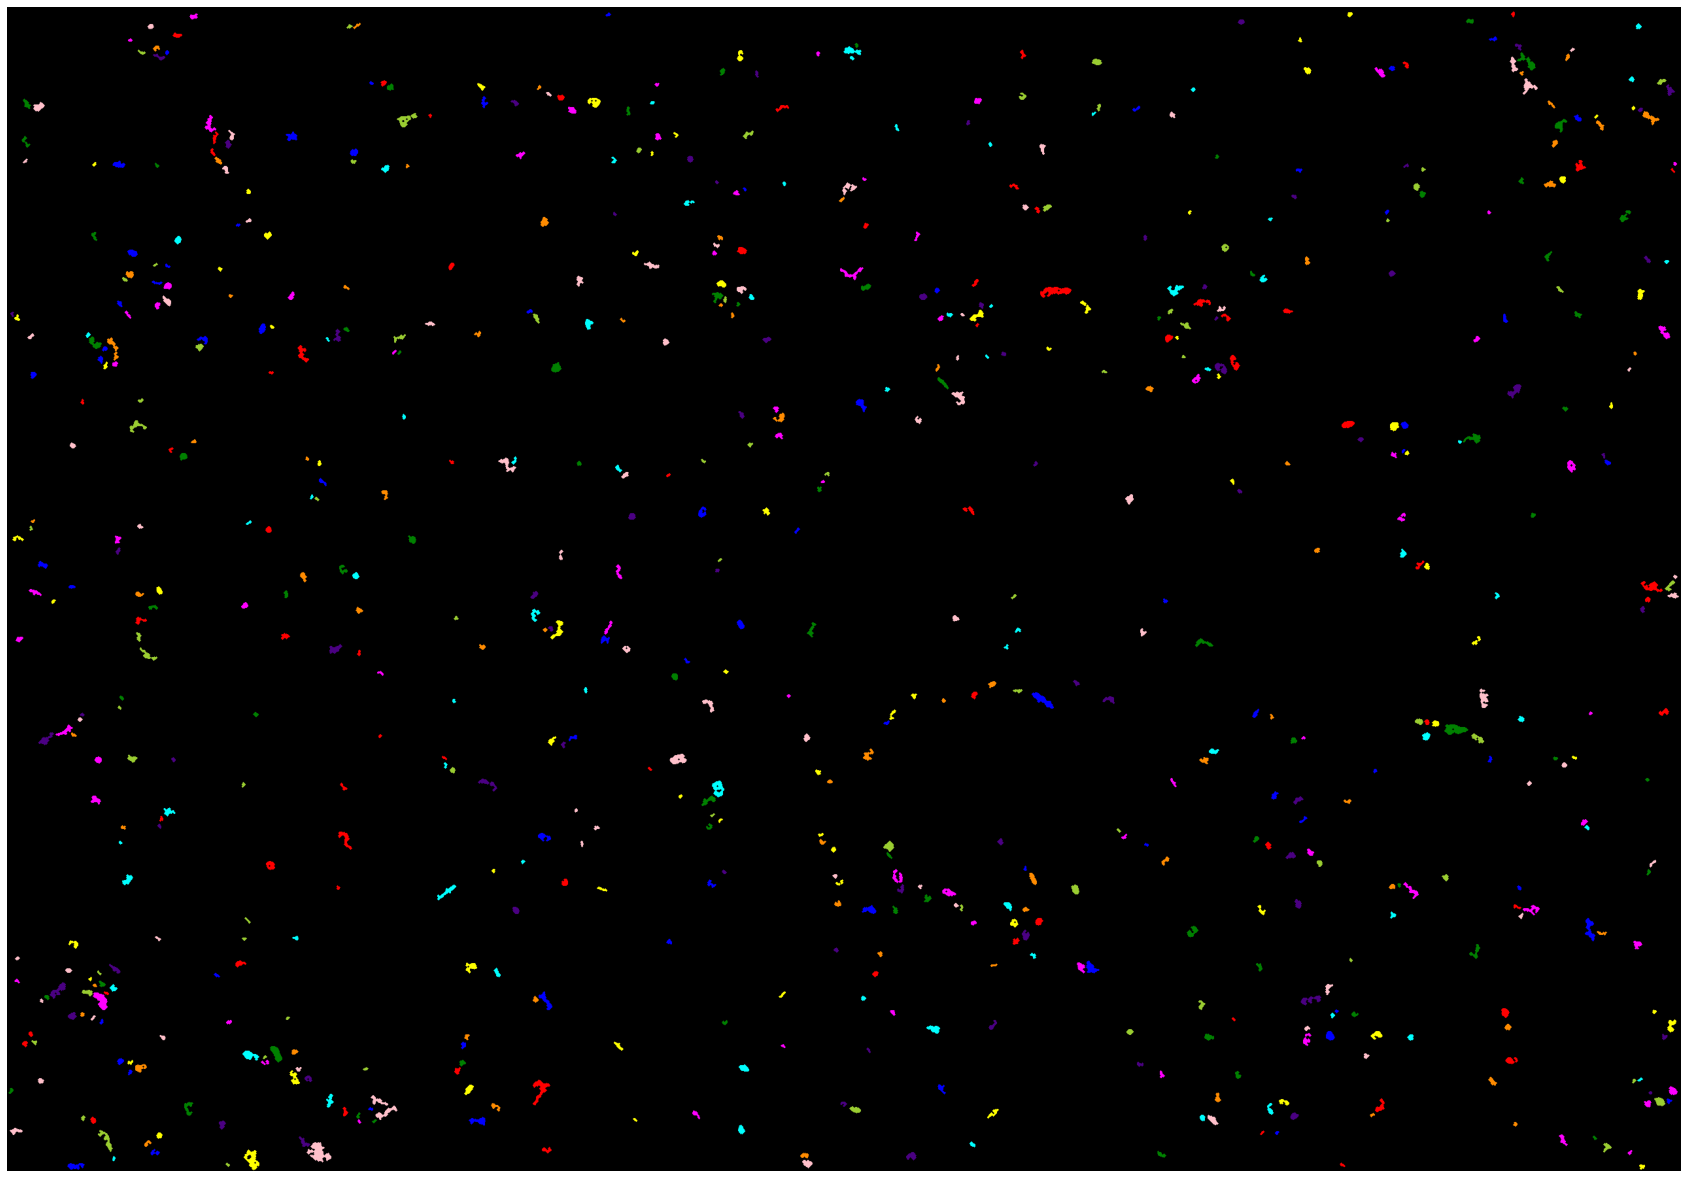

In [32]:
plt.figure(figsize=(30,30))
plt.axis('off')
plt.imshow(img2_label_overlay)

In [23]:
data_nm['area'].median()

55.0

In [24]:
!mkdir '/content/drive/MyDrive/CIOP/images/'RESULTS

mkdir: cannot create directory ‘/content/drive/MyDrive/CIOP/images/RESULTS’: File exists


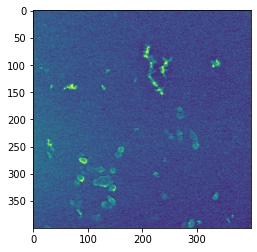

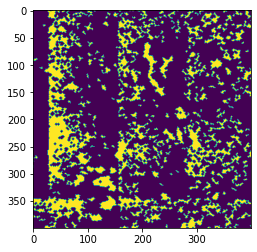

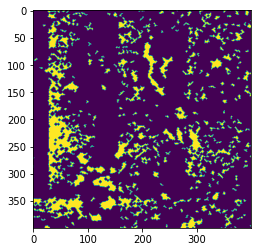

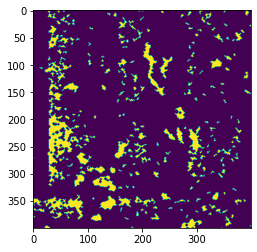

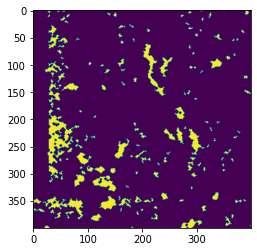

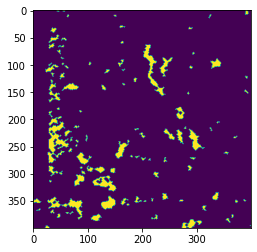

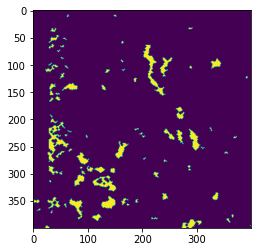

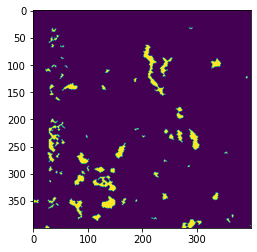

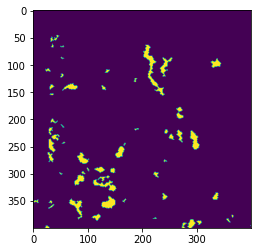

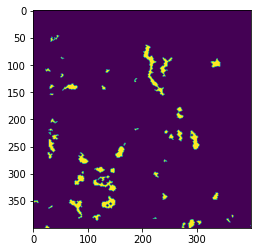

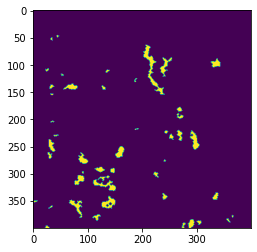

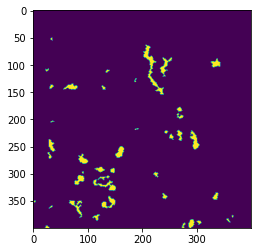

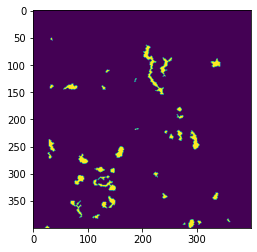

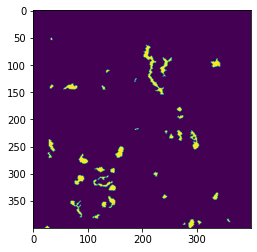

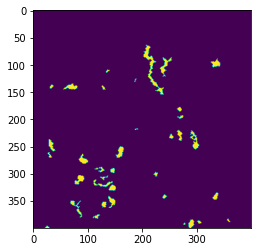

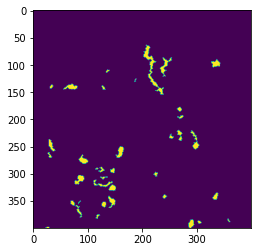

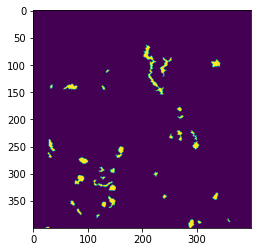

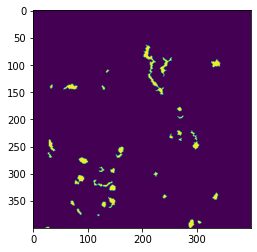

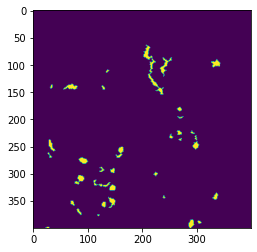

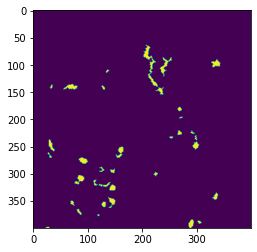

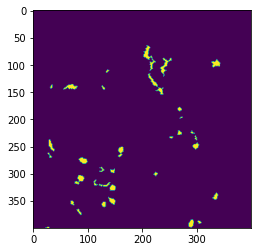

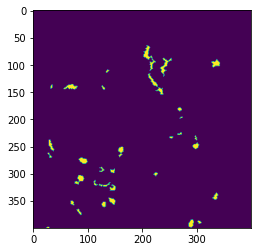

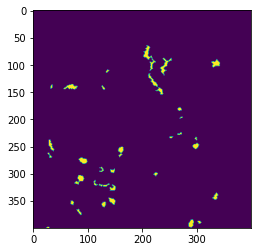

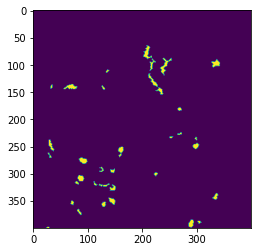

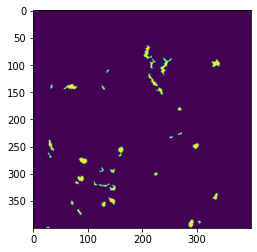

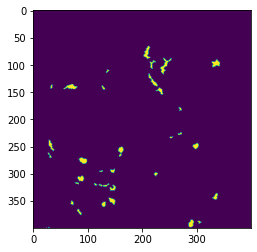

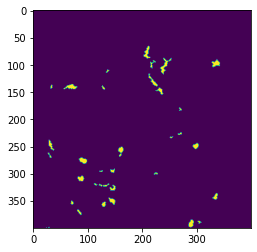

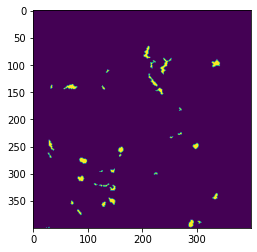

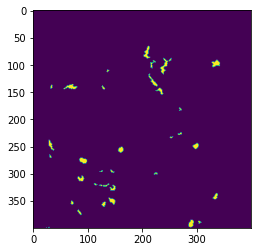

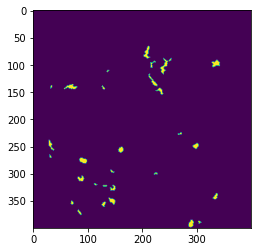

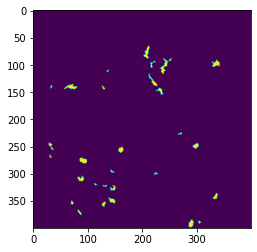

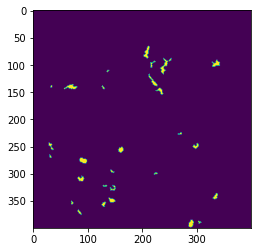

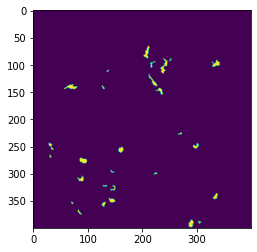

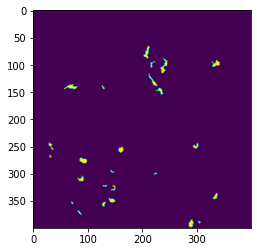

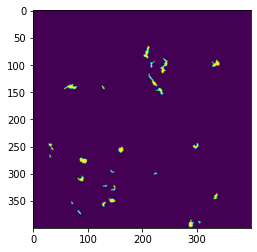

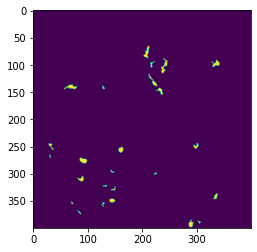

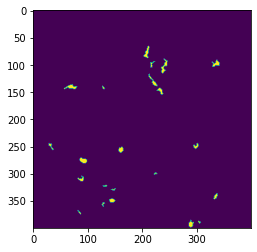

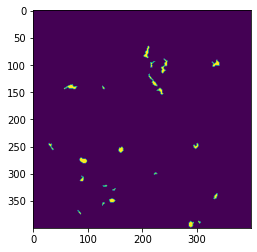

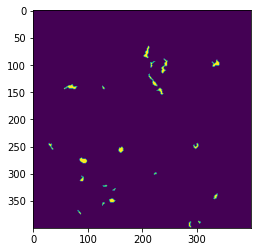

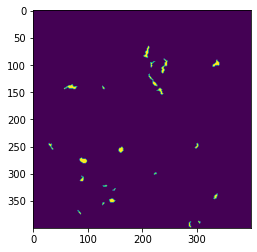

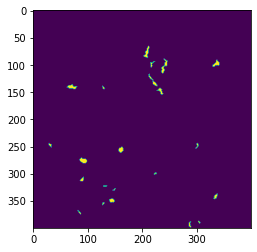

In [71]:
plt.imshow(img[100:500,100:500])
plt.show()
particles = []
for i in range(1,41):
    img_segm = segmentation(i,6,10,1)
    img2_label, img2_label_overlay, data_nm = label_img()
    particles.append([i,len(data_nm)])
    #name = sem_dict['ImageName'].split('.')[0]
    #plt.imsave('/content/drive/MyDrive/CIOP/images/RESULTS/'+name+str(i)+'.jpg', img2_label_overlay)

particles = pd.DataFrame(particles, columns=(['segm','number of particles']))

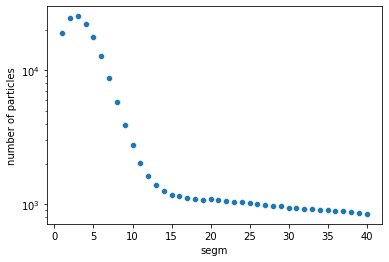

In [51]:
sns.scatterplot(data=particles,x='segm',y='number of particles')
plt.yscale('log')
yinterp = np.interp(particles['segm'], particles['segm'], particles['number of particles'])

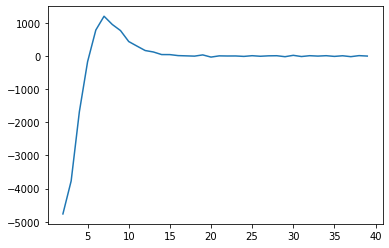

In [47]:
plt.plot(particles['number of particles'].diff().diff())

In [48]:
particles[['segm']].values.reshape(-1,1)

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [20],
       [21],
       [22],
       [23],
       [24],
       [25],
       [26],
       [27],
       [28],
       [29],
       [30],
       [31],
       [32],
       [33],
       [34],
       [35],
       [36],
       [37],
       [38],
       [39],
       [40]])

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [30]:
elbow = []
for i in range(2,20-2):
    lm = LinearRegression()
    temp = particles.copy()
    temp['number of particles'] = temp['number of particles']/temp['number of particles'].max()
    left = temp.iloc[:i,:]
    lm.fit(left[['segm']].values.reshape(-1,1),left['number of particles'].values)
    pred = lm.predict(left[['segm']].values.reshape(-1,1))
    mse_left = mean_squared_error(left[['number of particles']].values.reshape(-1,1),pred)
    right = temp.iloc[i:,:]
    lm.fit(right[['segm']].values.reshape(-1,1),right['number of particles'].values)
    pred = lm.predict(right[['segm']].values.reshape(-1,1))
    mse_right = mean_squared_error(right[['number of particles']].values.reshape(-1,1),pred)
    elbow.append([i,mse_left+mse_right])
print(elbow)
elbow = pd.DataFrame(elbow)

ValueError: ignored

In [ ]:
elbow

In [ ]:
elbow[elbow[1] == elbow[1].min()]

In [ ]:
m,b = np.polyfit(particles['segm'], particles['number of particles'], 1)

In [ ]:
b

In [ ]:
 data_nm['equivalent_diameter'].plot.hist(bins=50)

In [ ]:
data = [67,145, 137, 132, 131, 131, 130, 129, 128, 128, 127, 127, 127, 127, 131, 132, 131, 128, 126, 126, 127, 149, 138, 132, 130, 131, 129, 129, 127, 126, 125, 124, 123, 123, 124, 124, 124, 123, 122, 123, 129, 150, 138, 132, 129, 128, 127, 127, 126, 125, 122, 121, 119, 119, 118, 118, 118, 118, 118, 120, 131, 161, 141, 134, 131, 128, 127, 126, 125, 124, 121, 119, 117, 117, 115, 114, 113, 113, 114, 118, 136, 156, 143, 132, 128, 127, 126, 125, 125, 124, 120, 118, 116, 115, 112, 112, 110, 110, 111, 115, 135, 139, 134, 127, 125, 124, 123, 123, 122, 122, 118, 116, 115, 112, 111, 111, 108, 108, 109, 113, 130, 129, 125, 124, 123, 123, 123, 123, 121, 119, 117, 114, 112, 110, 108, 108, 106, 106, 106, 109, 119, 127, 122, 122, 122, 121, 121, 121, 120, 118, 116, 113, 110, 108, 106, 105, 104, 106, 104, 107, 112, 140, 125, 123, 122, 122, 121, 121, 119, 117, 114, 111, 109, 106, 104, 103, 102, 101, 102, 105, 108, 149, 129, 123, 122, 121, 120, 120, 117, 114, 111, 107, 105, 102, 101, 100, 99, 99, 100, 102, 105, 140, 129, 124, 122, 120, 120, 119, 115, 112, 108, 104, 101, 100, 99, 98, 98, 98, 99, 101, 105, 131, 126, 124, 122, 119, 118, 116, 114, 111, 107, 103, 98, 98, 98, 97, 97, 97, 99, 100, 104, 129, 126, 124, 121, 120, 118, 116, 113, 110, 106, 103, 96, 96, 97, 97, 96, 97, 101, 101, 104, 132, 127, 123, 120, 119, 118, 114, 111, 110, 105, 102, 99, 98, 96, 95, 95, 96, 97, 100, 104, 130, 125, 121, 119, 117, 114, 113, 109, 106, 104, 101, 98, 97, 95, 94, 95, 94, 95, 98, 101, 127, 123, 120, 117, 115, 112, 110, 107, 105, 102, 101, 98, 97, 94, 93, 93, 93, 94, 96, 99, 125, 122, 118, 115, 112, 110, 108, 105, 102, 100, 98, 97, 95, 93, 92, 91, 92, 92, 94, 97, 121, 119, 115, 113, 110, 108, 105, 103, 101, 99, 97, 96, 93, 92, 91, 91, 92, 92, 94, 97, 117, 117, 113, 113, 109, 106, 103, 101, 100, 97, 95, 94, 92, 91, 91, 90, 90, 92, 93, 97, 116, 117, 114, 111, 108, 105, 102, 100, 98, 97, 96, 93, 92, 90, 90, 90, 90, 91, 93, 97]

In [ ]:
np.max(data)

In [ ]:
np.median(data)

In [ ]:
Q1 ,Q2, Q3 = np.percentile(data, [25,50,75])

In [ ]:
print(Q1,Q2,Q3)

In [ ]:
IQR = Q3-Q1

In [ ]:
plt.boxplot(data)
plt.show()

In [ ]:
Q3+1.5*IQR

In [ ]:
Q1-1.5*IQR